In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold,StratifiedKFold, cross_val_score ,learning_curve ,ShuffleSplit,validation_curve,train_test_split

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

from copy import deepcopy
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

2022-12-06 11:40:27.129871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
trainDF = pd.read_csv('ProjectTrainingData.csv')


In [7]:
testDF = pd.read_csv('ProjectTestData.csv')
testDF = testDF[['hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]

In [8]:
pd.set_option("display.max_columns",None)

In [5]:
trainDF.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


# EDA and Data preparation

In [6]:
trainDF.shape

(31991090, 24)

In [7]:
trainDF.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [9]:
def shaffle_data(df): 
    df = df.sample(frac=1) # shuffle the data to split them to parts
    df = df.reset_index(drop=True)
    return df

In [10]:
def split_data(df, part):
    data_dic ={}

    # store splitted data in a dictionary
    for i in range(1,part+1):
        split_data = df.iloc[int(np.ceil(df.shape[0]/part)*(i-1)) : int(np.ceil(df.shape[0]/part)*i),:]
        data_dic['data'+str(i)] = split_data

    return data_dic

In [11]:
def convert_hour(df): # convert the feature 'hour' to two numerical variables
    df['hour'] = pd.to_datetime(df['hour'], format = '%y%m%d%H') 
    df['weekday'] = df['hour'].dt.weekday
    df['hour'] = df['hour'].dt.hour
    return df

In [12]:
def count_categories(df): # count the number of categories for each variables
    lst = []
    for i in df.columns:
        col = i
        num_cat = (df[i].nunique() )
        lst.append(num_cat)
    return lst

In [13]:
def get_X_y_test(part_of_data):
   traindf = 'data'+str(part_of_data)
   testdf = 'data'+str(part_of_data)
   
   df = all_tr[traindf]

   X = df.loc[:,['hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday']]
   y = df['click']

   testDF = all_test[testdf]

   return X, y,testDF

In [14]:
# convert the feature 'hour' to two numerical variables
train_cov = convert_hour(trainDF)
test_cov = convert_hour(testDF)

# split the train data and test data to 10 pieces
random_seed =42

part = 10 # split the data set to 10 parts

shuffle_train = shaffle_data(train_cov)
all_tr = split_data(shuffle_train,part)
all_test = split_data(test_cov,part)


In [55]:
# get the training dataset and test dataset
X, y,testDF = get_X_y_test(1)

In [56]:
### according to the cardinality of different categorical variables, 
### we can use our domain knowledge to determine to abandon some
### categories with high cardinality, and enable us to use one-hot
### encoding for the rest categorical features 
### (no relationship between categories, so we use one-hot encoding)
freq_X = count_categories(X)
freq_test = count_categories(testDF)
data = [X.columns,freq_X,freq_test]
overview = pd.DataFrame(data).T
overview.columns = ['feature','train','test']
overview


,feature,train,test
0,hour,24,24
1,C1,7,7
2,banner_pos,7,7
3,site_id,3285,2656
4,site_domain,4019,2902
5,site_category,24,22
6,app_id,4535,3366
7,app_domain,286,198
8,app_category,30,28
9,device_id,417743,161398


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa47a59700>],
      dtype=object)

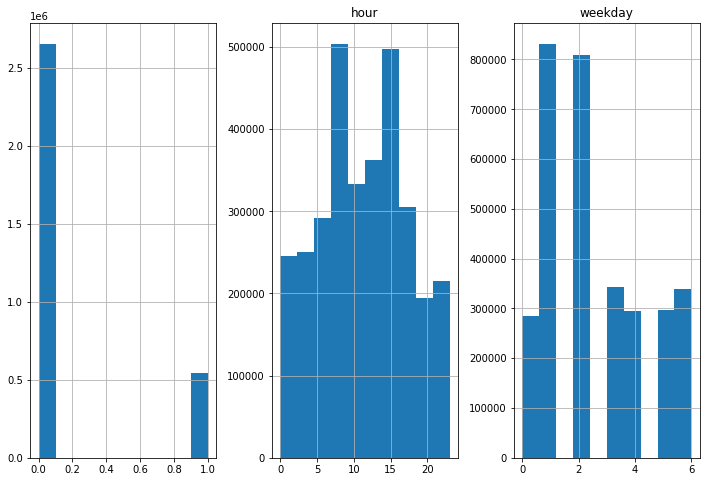

In [58]:
fig, axes = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = [12,8]


#target variable distribution
y.hist(ax = axes[0])

### the distribution of numerical variables
X.hist(column='hour' ,ax= axes[1])
X.hist(column='weekday' ,ax= axes[2])



# Featur Processing

## Frequency Encoding and Feature Engineering

In [59]:
### according to the cardinality of different categorical variables, 
### we can use frequency encoder to encode those categorical variables.

### encoding for the rest categorical features by creating dummies
### (no relationship between categories, so we use one-hot encoding)

def freq_encode(X,testDF,columns, threshold=10):

    total_df = pd.concat([X,testDF])

    for i in columns:

        # if the categories for this variable is larger than threshold, use frequency encoding
        if total_df[i].nunique() > threshold:
            freq = (total_df.groupby(i).size())/len(total_df) # get the frequency
            total_df[i] = total_df[i].apply(lambda x: freq[x]) # apply frequency to the categorical variable colume

        # if categories is less than threshold, create dummies for this variable
        if total_df[i].nunique() < threshold:
            temp_dummy = pd.get_dummies(total_df[i],drop_first=True) # create a temporary dataframe for the created dummies
            total_df.drop(i,axis=1, inplace=True) # drop the varibles from original dataset and append the dummies to it
            total_df = pd.concat([total_df,temp_dummy],axis=1)
            
    # split the dataset to training and test data
    X_final = total_df[0:X.shape[0]] 
    testDF_final = total_df[X.shape[0]:]

    return X_final, testDF_final


In [60]:
def scale_num_var(df, col):
    # standardize the numerical variables with MinMaxScaler for train and test data
    scaler = MinMaxScaler()
    scaler.fit(df[col])

    # transform the numerical column
    df[col] = scaler.transform(df[col])
    return df

In [61]:
def drop_dup_colname(df):
    cols=pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [str(dup) + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols

    return df

In [62]:
X = X

testDF = testDF

columns = ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
    'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
    'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
    'C17', 'C18', 'C19', 'C20', 'C21']

X_final, testDF_final = freq_encode(X,testDF,columns, threshold=10) # Encode categorical variables with high cardinality


# rename duplicated col names
X_final = drop_dup_colname(X_final) 
X_final.columns = X_final.columns.astype(str)
testDF_final = drop_dup_colname(testDF_final)

# Core Modeling Function

In [140]:
def nn_model(NEpochs, BatchSize, Optimizer, X, y,X_test):
    SpiralNN = Sequential()

    SpiralNN.add(Dense(units=20,input_shape=(X.shape[1],),activation="relu",use_bias=True))
    SpiralNN.add(Dense(units=15,activation="relu",use_bias=True))
    SpiralNN.add(Dense(units=10,use_bias=True))
    SpiralNN.add(LeakyReLU(alpha=0.05))
    SpiralNN.add(Dense(units=5,activation="relu",use_bias=True))
    SpiralNN.add(Dense(units=1,activation="sigmoid",use_bias=True))

    SpiralNN.compile(loss='binary_crossentropy', optimizer=Optimizer,metrics=['binary_crossentropy','accuracy'])

    StopRule = EarlyStopping(monitor='binary_crossentropy',mode='min',verbose=0,patience=100,min_delta=0.0)
    FitHist = SpiralNN.fit(X,y,\
                        epochs=NEpochs,batch_size=BatchSize,verbose=0, \
                        callbacks=[StopRule])
    
    
    return SpiralNN

In [64]:
def xgboost_bp(X,y):
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='logloss',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    clf0 = GridSearchCV(estimator=xgbc0, scoring='neg_log_loss', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
    clf0.fit(X, y.values.ravel())

    params = deepcopy(default_params)

    param_grid = {'max_depth': range (2, 10, 1),
                'n_estimators': range(60, 220, 40),
                'learning_rate': [1,0.1, 0.01 , 0.05],
                'tree_method':['hist'],
                'eval_metric':['logloss']}

    gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
    for i,grid_key in enumerate(param_grid.keys()):
        
        #creating param_grid argument for GridSearchCV:
        #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
        for param_key in params.keys():
            if param_key == grid_key:
                params[param_key] = param_grid[grid_key]
            else:
                #use best parameters of last iteration
                try:
                    param_value = [clf.best_params_[param_key]]
                    params[param_key] = param_value
                #use benchmark model parameters for first iteration
                except:
                    param_value = [clf0.best_params_[param_key]]
                    params[param_key] = param_value
        
        #classifier instance of current iteration
        xgbc = xgb.XGBClassifier(**default_params)
        
        #GridSearch instance of current iteration
        clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='neg_log_loss', return_train_score=True, verbose=0, cv=5)
        gs_clf = clf.fit(X, y.values.ravel())  

        #best parameters
        bp = gs_clf.best_params_

    return bp

# Modeling & Prediction

In [65]:
X_train, X_test,y_train, y_test = train_test_split(X_final,y,test_size=0.3,random_state=42) # split this part of data to train and test data

################################### XGBoost #######################################

In [66]:
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='logloss',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

clf0 = GridSearchCV(estimator=xgbc0, scoring='neg_log_loss', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None,
                                     grow_policy='lossguide',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     lea...
                         'max_cat_threshold': [None],
                         'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         'max_depth': [None], 'max_leaves': [None],
                         'min_child_weight': [None], 'missing': [nan],
                         'monotone_constraints': [None], 'n_estimators': [100],
                         'n_jobs': [None], 'num_parallel_tree': [None],
                         'objective': ['binary:logistic'], 'predictor': [None], ...},
             return_train_score=True, scoring='neg_log_loss', verbose=1)

In [74]:
pred_xg = clf0.predict_proba(X_test)[:,1]

In [80]:
print(log_loss(y_test,pred_xg))

0.3961504432088541


################################### CATBoost #####################################

In [88]:
CBC_test = CatBoostClassifier() # use default params
CBC_test = CBC_test.fit(X_final,y)
pred_Cat = CBC_test.predict_proba(X_test)[:,1]


Learning rate set to 0.323282
0:	learn: 0.5378365	total: 273ms	remaining: 4m 32s
1:	learn: 0.4737658	total: 438ms	remaining: 3m 38s
2:	learn: 0.4471391	total: 600ms	remaining: 3m 19s
3:	learn: 0.4358405	total: 744ms	remaining: 3m 5s
4:	learn: 0.4292391	total: 911ms	remaining: 3m 1s
5:	learn: 0.4255785	total: 1.07s	remaining: 2m 57s
6:	learn: 0.4232537	total: 1.24s	remaining: 2m 55s
7:	learn: 0.4212973	total: 1.39s	remaining: 2m 52s
8:	learn: 0.4202859	total: 1.52s	remaining: 2m 47s
9:	learn: 0.4195170	total: 1.68s	remaining: 2m 46s
10:	learn: 0.4179801	total: 1.84s	remaining: 2m 45s
11:	learn: 0.4171362	total: 2s	remaining: 2m 44s
12:	learn: 0.4166975	total: 2.15s	remaining: 2m 42s
13:	learn: 0.4159771	total: 2.29s	remaining: 2m 41s
14:	learn: 0.4151771	total: 2.43s	remaining: 2m 39s
15:	learn: 0.4144868	total: 2.59s	remaining: 2m 39s
16:	learn: 0.4141522	total: 2.78s	remaining: 2m 40s
17:	learn: 0.4137457	total: 2.96s	remaining: 2m 41s
18:	learn: 0.4134142	total: 3.14s	remaining: 2m 4

In [90]:
print('log loss of CATBoost is: ', str(log_loss(y_test,pred_Cat)))

log loss of CATBoost is:  0.39311635972273495


################################### Logistic Regression #######################################

In [76]:
# Standardize the data
col = ['hour','weekday']
X_sc = scale_num_var(X_final, col) # transform training dataset
testDF_sc = scale_num_var(testDF_final, col) # transform test dataset

X_final_sc = drop_dup_colname(X_sc)
testDF_final_sc = drop_dup_colname(testDF_sc)


In [77]:
X_train_sc, X_test_sc,y_train_sc, y_test_sc = train_test_split(X_final_sc,y,test_size=0.3,random_state=42) # split this part of data to train and test data

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


lr = LogisticRegression(C=0.01, random_state=42, solver='lbfgs',penalty = 'l2') # build the logistic model
lr = lr.fit(X_train_sc,y_train_sc)

pred_proba = lr.predict_proba(X_test_sc) # get the predicted probability

# calculate loss
lr_loss = log_loss(y_test_sc,pred_proba[:,1])
lr_loss

/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4304583977541348

###################################### Neural Network ######################################

In [84]:
NEpochs = 200
BatchSize= 1000
Optimizer=optimizers.RMSprop(learning_rate=0.001)

In [82]:
from keras.layers import LeakyReLU
SpiralNN = Sequential()

SpiralNN.add(Dense(units=20,input_shape=(X_train_sc.shape[1],),activation="relu",use_bias=True))
SpiralNN.add(Dense(units=15,activation="relu",use_bias=True))
SpiralNN.add(Dense(units=10,use_bias=True))
SpiralNN.add(LeakyReLU(alpha=0.05))
SpiralNN.add(Dense(units=5,activation="relu",use_bias=True))
SpiralNN.add(Dense(units=1,activation="sigmoid",use_bias=True))

SpiralNN.compile(loss='binary_crossentropy', optimizer=Optimizer,metrics=['binary_crossentropy','accuracy'])
print(SpiralNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1080      
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,616
Trainable params: 1,616
Non-trainabl

2022-12-06 14:01:48.281163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [85]:
#%% Fit NN Model

from keras.callbacks import EarlyStopping


StopRule = EarlyStopping(monitor='binary_crossentropy',mode='min',verbose=0,patience=100,min_delta=0.0)
FitHist = SpiralNN.fit(X_train_sc,y_train_sc,\
                    epochs=NEpochs,batch_size=BatchSize,verbose=0, \
                    callbacks=[StopRule])
    
#FitHist = SpiralNN.fit(TrXrsc,TrColorCode,epochs=NEpochs,batch_size=BatchSize,verbose=0)

TestP = SpiralNN.predict(X_test_sc,batch_size = X_train_sc.shape[0])

print("Number of Epochs = "+str(len(FitHist.history['accuracy'])))
print("Log loss: "+str(log_loss(y_test_sc,TestP)))

1/1 [==============================] - 1s 500ms/step
Number of Epochs = 200
Log loss: 0.41347576628246857


# Compare Model Performance with Best Parameters & Predict Probability for Test Data

In [86]:
from sklearn.metrics import log_loss

In [51]:
val_test=[]
for i in [1,2,3,4,6,7,8,9,10]:
    X,y,testDF = get_X_y_test(i)


    X[columns] = X[columns].astype('category') # change the data type of categorical variables to category

    X.columns = X.columns.astype(str) # change all column name to string
        

    # rename duplicated col names
    X_final = drop_dup_colname(X) 
    pred = CBC.predict_proba(X_final)[:,1]
    val_test.append(log_loss(y,pred))

In [52]:
val_test

[0.3857151160361722,
 0.3854864480187115,
 0.3850835088310268,
 0.3855738207770144,
 0.38580913894204016,
 0.38505835398800164,
 0.38580341039310306,
 0.3860189855345325,
 0.2784329163884995]

In [48]:
log_loss(y,pred[:,1])

0.3857151160361722

In [54]:
X,y,testDF = get_X_y_test(5)


X[columns] = X[columns].astype('category') # change the data type of categorical variables to category

X.columns = X.columns.astype(str) # change all column name to string
    

# rename duplicated col names
X_final = drop_dup_colname(X) 
pred = CBC.predict_proba(X_final)[:,1]
log_loss(y,pred)

0.385929896129409

In [94]:
def pred_test_fun(part,method):
    X,y,testDF = get_X_y_test(part)

    columns = ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
    'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
    'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
    'C17', 'C18', 'C19', 'C20', 'C21']

    if part <= 5: # if we took one part of the first five part of data, we take the 10th part of data as the validation data
        X_val,y_val,testDF_val = get_X_y_test(10)
    if part >5:
        X_val,y_val,testDF_val = get_X_y_test(1)
    X_val_final, testDF_val_final = freq_encode(X_val,testDF_val,columns, threshold=10) # Encode categorical variables with high cardinality
    X_val_final.columns = X_val_final.columns.astype(str)
    X_val_final = drop_dup_colname(X_val_final)

    if method == 'CATboost':
        X,y,testDF = get_X_y_test(part)

        X[columns] = X[columns].astype('category') # change the data type of categorical variables to category

        X.columns = X.columns.astype(str) # change all column name to string
            

        # rename duplicated col names
        X_final = drop_dup_colname(X) 
        testDF_final = drop_dup_colname(testDF)

        #X_train, X_test,y_train, y_test = train_test_split(X_final,y,test_size=0.3,random_state=42) # split this part of data to train and test data

        CBC = CatBoostClassifier(cat_features=columns)


        parameters = {'depth'  : [10,15,20],
                      'learning_rate' : [0.02,0.1,0.3],
                      'iterations'    : [50,300],
                      'one_hot_max_size': [2,10,15]
                    }

        Grid_CBC = GridSearchCV(estimator=CBC,scoring='neg_log_loss',param_grid = parameters, cv = 3, n_jobs=-1)
        Grid_CBC.fit(X_final, y)

        #pred_test = Grid_CBC.predict(testDF_final)

        logloss = log_loss(y_val,Grid_CBC.predict_proba(X_val_final))
        best_params_cat = Grid_CBC.best_params_

        return Grid_CBC,best_params_cat,logloss

        

    if method == 'XGboost':
        X_final, testDF_final = freq_encode(X,testDF,columns, threshold=10) # Encode categorical variables with high cardinality
        X_final.columns = X_final.columns.astype(str)
            

        # rename duplicated col names
        X_final = drop_dup_colname(X_final) 
        testDF_final = drop_dup_colname(testDF_final)

        # rename duplicated col names
        X_final = drop_dup_colname(X_final) 
        testDF_final = drop_dup_colname(testDF_final)

        

        # get the Best_Parameter for xgboost
        Best_Parameter = xgboost_bp(X_final,y)
        
        xgbc0 = xgb.XGBClassifier(**Best_Parameter)
        xgbc = xgbc0.fit(X_final,y)

        #pred_test = xgbc.predict_proba(testDF_final)[:,1]
        
        logloss = log_loss(y_val,xgbc.predict_proba(X_val_final)[:,1])
        return xgbc,Best_Parameter,logloss

    if method =='logisitc_regression':
        X_final, testDF_final = freq_encode(X,testDF,columns, threshold=10) # Encode categorical variables with high cardinality
        X_final.columns = X_final.columns.astype(str)

        # rename duplicated col names
        X_final = drop_dup_colname(X_final) 
        testDF_final = drop_dup_colname(testDF_final)

        # Standardize the data
        col = ['hour','weekday']
        X_final_sc = scale_num_var(X_final, col) # transform training dataset
        X_testDF_sc = scale_num_var(testDF_final, col) # transform test dataset

        X_train_sc, X_test_sc,y_train_sc, y_test_sc = train_test_split(X_final_sc,y,test_size=0.3,random_state=42) # split this part of data to train and test data
        
        lr = LogisticRegression(C=0.01, random_state=42, solver='lbfgs',penalty = 'l2') # build the logistic model
        lr = lr.fit(X_final_sc,y)

        #pred_test = lr.predict_proba(X_testDF_sc)
        logloss = log_loss(y_val,lr.predict_proba(X_val_final)[:,1])
        return lr,logloss

    if method == 'neural_network':
        X_final, testDF_final = freq_encode(X,testDF,columns, threshold=10) # Encode categorical variables with high cardinality
        X_final.columns = X_final.columns.astype(str)
        
        # rename duplicated col names
        X_final = drop_dup_colname(X_final) 
        testDF_final = drop_dup_colname(testDF_final)

        # Standardize the data
        col = ['hour','weekday']
        X_final_sc = scale_num_var(X_final, col) # transform training dataset
        X_testDF_sc = scale_num_var(testDF_final, col) # transform test dataset
        X_train_sc, X_test_sc,y_train_sc, y_test_sc = train_test_split(X_final_sc,y,test_size=0.3,random_state=42) # split this part of data to train and test data

        # get the output and NN model from the defined function
        SpiralNN = nn_model(250,400,optimizers.RMSprop(learning_rate=0.001),X_final_sc,y,X_testDF_sc)

        logloss = log_loss(y_val,SpiralNN.predict(X_val_final,batch_size=X_final_sc.shape[0]))
        return SpiralNN,logloss

In [92]:
part = 1 # Specify the first part of data to train the model

In [26]:
# try 'XGboost','CATBoost','logisitc_regression' and 'neural_network' in the second arg, keep the one with lowest logloss,
# then write it out in next chunk of code

NN_model,logloss = pred_test_fun(part,'neural_network')
print(logloss)

1/1 [==============================] - 1s 578ms/step
0.4163898422347551


In [27]:
XG_model,XG_bp,logloss_XG = pred_test_fun(part,'XGboost')
print(logloss_XG)

C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\jwa2238\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`

0.39057681333350874


In [95]:
lr_model,logloss_lr = pred_test_fun(part,'logisitc_regression')
print(logloss_lr)

/Users/nigelsimida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4451378281035794


### Due to limited memory of my local PC and low efficiency of CATBoost, I implemented the function "pred_test_fun(1,'CATBoost')". The hyperparameter tuning process gives the best parameters for CATBoost as follows: bp_CAT = {'depth': 15,'learning_rate': 0.1,'iterations': 300,'one_hot_max_size': 10}, so I trained my CATBoost model with the given besst parameters

In [97]:
columns = ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
    'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
    'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
    'C17', 'C18', 'C19', 'C20', 'C21']

In [107]:
X,y_cat,testDF_cat = get_X_y_test(10)

X[columns] = X[columns].astype('category') # change the data type of categorical variables to category
testDF_cat[columns] = testDF_cat[columns].astype('category')
testDF_cat.columns = testDF_cat.columns.astype(str)
X.columns = X.columns.astype(str) # change all column name to string
    

# rename duplicated col names
X_final_cat = drop_dup_colname(X) 

/var/folders/m1/kt43_1vj58b_mx4h1rjqj0940000gn/T/ipykernel_40661/554052727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF_cat[columns] = testDF_cat[columns].astype('category')


In [139]:
lr_model

LogisticRegression(C=0.01, random_state=42)

In [24]:
CBC = CatBoostClassifier(cat_features=columns,depth=15,learning_rate = 0.1, iterations = 300,one_hot_max_size=10)
CBC =CBC.fit(X_final_cat,y_cat)

0:	learn: 0.6253151	total: 9.95s	remaining: 49m 33s
1:	learn: 0.5750125	total: 18.9s	remaining: 47m 3s
2:	learn: 0.5359508	total: 29.2s	remaining: 48m 9s
3:	learn: 0.5064213	total: 37.4s	remaining: 46m 7s
4:	learn: 0.4826467	total: 47.9s	remaining: 47m 5s
5:	learn: 0.4651778	total: 57.6s	remaining: 47m 3s
6:	learn: 0.4510872	total: 1m 7s	remaining: 47m 11s
7:	learn: 0.4404649	total: 1m 17s	remaining: 46m 52s
8:	learn: 0.4322554	total: 1m 26s	remaining: 46m 43s
9:	learn: 0.4258370	total: 1m 36s	remaining: 46m 24s
10:	learn: 0.4204279	total: 1m 45s	remaining: 46m 24s
11:	learn: 0.4161623	total: 1m 57s	remaining: 47m 5s
12:	learn: 0.4126620	total: 2m 8s	remaining: 47m 15s
13:	learn: 0.4095667	total: 2m 20s	remaining: 47m 43s
14:	learn: 0.4075348	total: 2m 30s	remaining: 47m 48s
15:	learn: 0.4055649	total: 2m 42s	remaining: 47m 59s
16:	learn: 0.4038016	total: 2m 53s	remaining: 48m 13s
17:	learn: 0.4022784	total: 3m 3s	remaining: 47m 47s
18:	learn: 0.4013000	total: 3m 15s	remaining: 48m 10s

## we conclude that CATBoost gives the best performance, so we use this model to predict all the test data

In [119]:
testDF = pd.read_csv('ProjectTestData.csv')
testDF = testDF[['hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]
test_cov = convert_hour(testDF)
testDF_cat[columns] = testDF_cov[columns].astype('category')
testDF_cat.columns = testDF_cat.columns.astype(str)

In [126]:
testDF_cat = test_cov
testDF_cat[columns] = testDF_cat[columns].astype('category')
testDF_cat.columns = testDF_cat.columns.astype(str)

In [127]:
testDF_cat

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,9,1005,1,85f751fd,c4e18dd6,50e219e0,1dc72b4d,2347f47a,0f2161f8,cd915ca3,834cff24,0d8ce284,1,0,8334,300,50,761,3,175,100075,23,1
1,20,1007,0,85f751fd,c4e18dd6,50e219e0,8311368f,1dc9b529,0f2161f8,ec0aff16,6f6d6456,6fe5a545,1,2,24303,320,50,2788,3,295,100194,240,4
2,9,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,bd807c39,a2f15940,1,0,24165,320,50,2776,0,35,-1,79,4
3,1,1002,0,48c42b43,de0f0f82,50e219e0,ecad2386,7801e8d9,07d7df22,dfb9b781,5ce9f91d,a0215413,0,0,23438,320,50,2684,2,1327,-1,52,4
4,19,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0da60c14,5096d134,1,0,24084,320,50,2761,2,35,100148,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13015336,10,1005,0,28616ed9,3bcb0c02,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,e873c589,41971090,1,0,23866,320,50,2736,3,33,100170,246,3
13015337,8,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,61de248f,779d90c2,1,0,23725,320,50,2716,3,47,-1,23,3
13015338,23,1005,0,17d1b03f,f3845767,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a05ff870,4ea23a13,1,0,22104,320,50,2545,0,431,-1,221,4
13015339,9,1005,0,85f751fd,c4e18dd6,50e219e0,ce183bbd,ae637522,cef3e649,a99f214a,24917551,36b67a2a,1,0,24132,320,50,2768,1,167,100192,71,4


In [128]:
pred_test_cat = CBC.predict_proba(testDF_cat)[:,1]

# Submission

In [130]:
sub = pd.read_csv('ProjectSubmission-TeamX.csv')
sub

,id,P(click)
0,3295858251275419735,0.5
1,12281702837842634283,0.5
2,4638380339534007785,0.5
3,17039804736879076347,0.5
4,5753064066292192109,0.5
...,...,...
13015336,13925888664291307582,0.5
13015337,16609686573956964319,0.5
13015338,4549134116722204000,0.5
13015339,2114008866308662546,0.5


In [134]:
sub['P(click)'] = pred_test_cat
sub = sub.set_index('id')
sub

,P(click)
id,
3295858251275419735,0.096083
12281702837842634283,0.195642
4638380339534007785,0.039631
17039804736879076347,0.069791
5753064066292192109,0.209716
...,...
13925888664291307582,0.023431
16609686573956964319,0.320530
4549134116722204000,0.167040


In [135]:
sub.to_csv('ProjectSubmission-Team10.csv')